# Imports

In [17]:
# Project setup and imports
import os, sys, random
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from svgutils.compose import Figure, Panel, SVG
import pickle
from matplotlib import colors as mcolors
from scipy.signal import savgol_filter

# Locate project root and add to path
cwd = Path.cwd()
PROJECT_ROOT = next((p for p in [cwd, *cwd.parents] if (p / 'src').exists()), cwd)
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# Project-specific imports
from src.simulation import SR_sim
from src.plotting import SR_plotting
import src.sr_utils as utils
import src.correlation_analysis as ca
import src.twin_analysis as ta
import src.gamma_gompertz as gg
import src.hetero_plotting as hp
from src.HMD_lifetables import HMD
import saved_results.twin_studies_data as td
import saved_results.model_param_calibrations as pc

# Reproducibility setup
SEED = int(os.environ.get('PYTHONHASHSEED', '12345'))
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
RNG = np.random.default_rng(12345)

# Deterministic sampling helpers
def choice_deterministic(a, size=None, replace=True, p=None):
    return RNG.choice(a, size=size, replace=replace, p=p)

def rand_uniform(size=None):
    return RNG.random(size)

# Matplotlib configuration
mpl.rcParams['font.family'] = 'Arial'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# Plot styling
plt.rc('axes', facecolor='white', grid=False)
plt.rc('axes.spines', top=False, right=False)
plt.rc('font', size=16)
plt.rc('axes', titlesize=28, labelsize=24)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('xtick.major', size=8, width=2.5)
plt.rc('ytick.major', size=8, width=2.5)
plt.rc('xtick.minor', size=5, width=2.5)
plt.rc('ytick.minor', size=5, width=2.5)
plt.rc('legend', fontsize=16)
plt.rc('figure', titlesize=28)

def remove_top_right_spines(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

# Jupyter extensions
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import os
sr_path = os.path.join(PROJECT_ROOT, 'saved_results')

with open(os.path.join(sr_path, 'swedish_GG_correlation_matrices.pkl'), 'rb') as f:
    swedish_gg_correlation_matrices = pickle.load(f)
with open(os.path.join(sr_path, 'swedish_SR_correlation_matrices.pkl'), 'rb') as f:
    swedish_sr_correlation_matrices = pickle.load(f)
with open(os.path.join(sr_path, 'danish_GG_correlation_matrices.pkl'), 'rb') as f:
    danish_gg_correlation_matrices = pickle.load(f)
with open(os.path.join(sr_path, 'danish_SR_correlation_matrices.pkl'), 'rb') as f:
    danish_sr_correlation_matrices = pickle.load(f)
with open(os.path.join(sr_path, 'satsa_GG_correlation_matrices.pkl'), 'rb') as f:
    satsa_gg_correlation_matrices = pickle.load(f)
with open(os.path.join(sr_path, 'satsa_SR_correlation_matrices.pkl'), 'rb') as f:
    satsa_sr_correlation_matrices = pickle.load(f)

filtered_ages = pc.filtered_ages
h_exts = pc.h_exts



# Figure

## New Forest Plot

Weighted estimate: 0.5511
Weighted standard error: 0.0087
Weighted confidence interval: (0.5340, 0.5682)


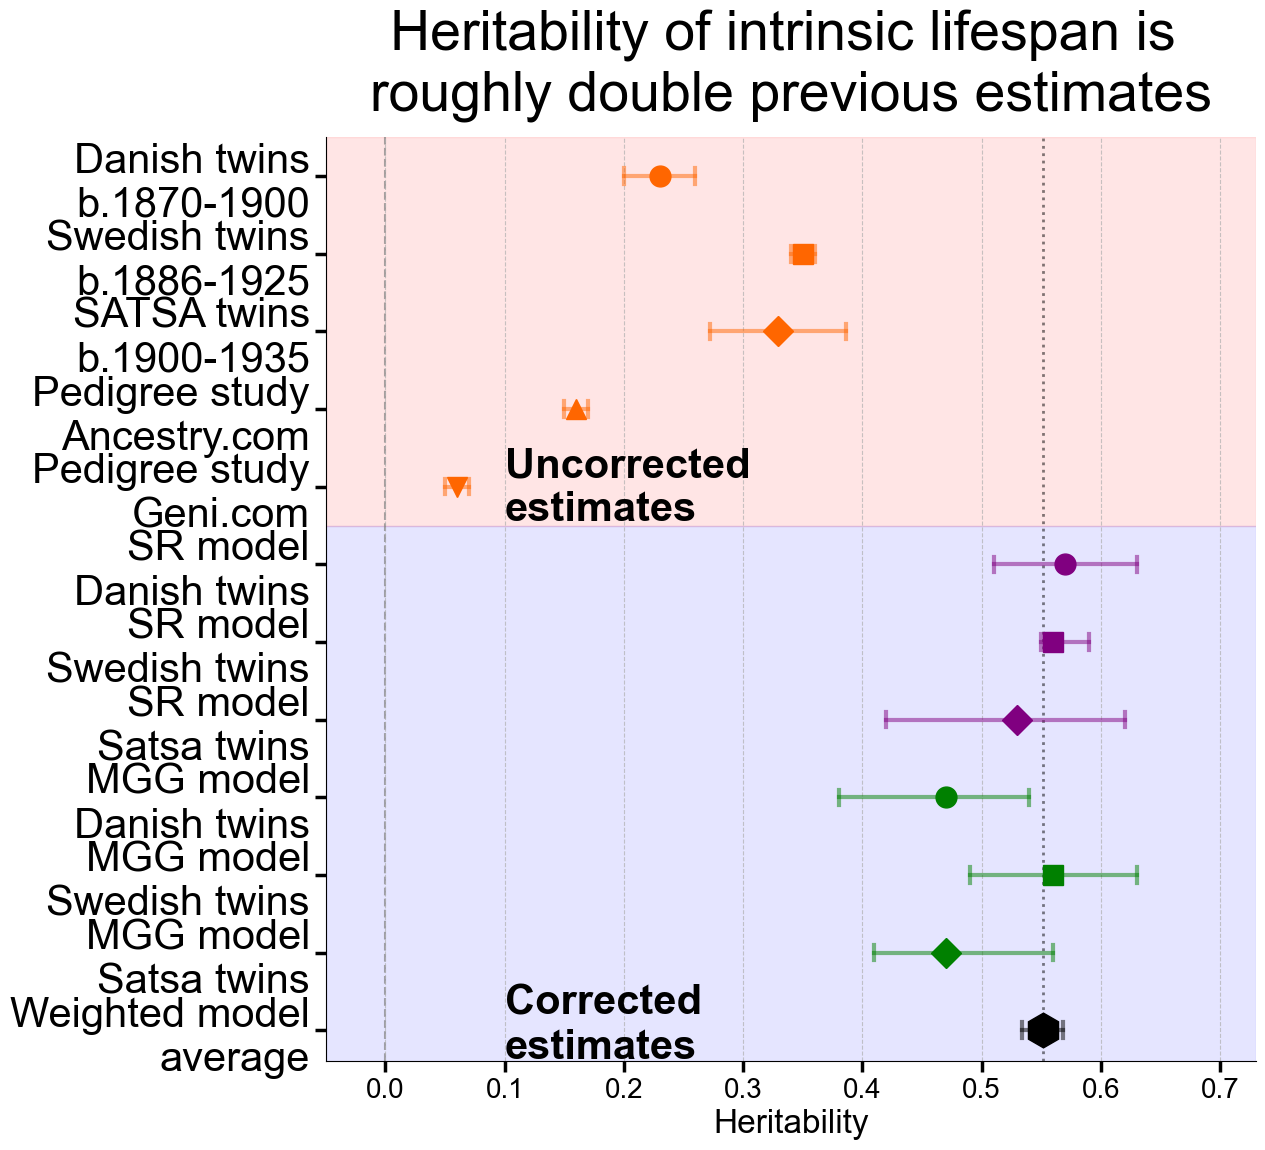

In [10]:
# Import necessary libraries for plotting
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle

def plot_heritability_forest_plot(ax):
    """Creates a forest plot of heritability estimates on the given axis."""
    # Define parameters
    cohorts = ['danish', 'swedish', 'satsa']
    models = ['SR', 'GG']
    colors = {'SR': 'purple', 'GG': 'green'}
    markers = {'danish': 'o', 'swedish': 's', 'satsa': 'D'}
    cutoff_age = 15
    log10h_ext = -30  # Asymptotic value
    
    # Define all data items with their display order (higher numbers appear at top)
    data_items = {
        'weighted_avg': {
            'order': 11,
            'label': "Weighted model\naverage",
            'estimate': None,  # Will be calculated
            'ci': None,  # Will be calculated
            'style': ('black', 'h')
        },
        'mgg_satsa': {
            'order': 10,
            'label': "MGG model\nSatsa twins",
            'estimate': None,  # Will be calculated from model
            'ci': None,
            'style': (colors['GG'], markers['satsa'])
        },
        'mgg_swedish': {
            'order': 9,
            'label': "MGG model\nSwedish twins",
            'estimate': None,  # Will be calculated from model
            'ci': None,
            'style': (colors['GG'], markers['swedish'])
        },
        'mgg_danish': {
            'order': 8,
            'label': "MGG model\nDanish twins",
            'estimate': None,  # Will be calculated from model
            'ci': None,
            'style': (colors['GG'], markers['danish'])
        },
        'sr_satsa': {
            'order': 7,
            'label': "SR model\nSatsa twins",
            'estimate': None,  # Will be calculated from model
            'ci': None,
            'style': (colors['SR'], markers['satsa'])
        },
        'sr_swedish': {
            'order': 6,
            'label': "SR model\nSwedish twins",
            'estimate': None,  # Will be calculated from model
            'ci': None,
            'style': (colors['SR'], markers['swedish'])
        },
        'sr_danish': {
            'order': 5,
            'label': "SR model\nDanish twins",
            'estimate': None,  # Will be calculated from model
            'ci': None,
            'style': (colors['SR'], markers['danish'])
        },
        'aggregated_pedigree': {
            'order': 4,
            'label': "Pedigree study\nGeni.com",
            'estimate': 0.06,
            'ci': (0.05, 0.07),
            'style': ('#FF6600', 'v')
        },
        'crowd_pedigree': {
            'order': 3,
            'label': "Pedigree study\nAncestry.com",
            'estimate': 0.16,
            'ci': (0.15, 0.17),
            'style': ('#FF6600', '^')
        },
        'satsa_twins': {
            'order': 2,
            'label': "SATSA twins\nb.1900-1935",
            'estimate': 0.3293,
            'ci': (0.3293 - 0.0569, 0.3293 + 0.0569),
            'style': ('#FF6600', markers['satsa'])
        },
        'swedish_twins': {
            'order': 1,
            'label': "Swedish twins\nb.1886-1925",
            'estimate': 0.35,
            'ci': (0.34, 0.36),
            'style': ('#FF6600', markers['swedish'])
        },
        'danish_twins': {
            'order': 0,
            'label': "Danish twins\nb.1870-1900",
            'estimate': 0.23,
            'ci': (0.20, 0.26),
            'style': ('#FF6600', markers['danish'])
        }
    }
    
    # Calculate model estimates
    model_data = []
    for cohort in cohorts:
        # SR model
        h2_result = pc.get_correlation_value(model='SR', filter_age=cutoff_age, 
                                          log10h_ext=log10h_ext, metric='h2', cohort=cohort)
        h2_parts = h2_result.replace('(', '').replace(')', '').split()
        estimate, lower, upper = float(h2_parts[0]), float(h2_parts[1].strip(',')), float(h2_parts[2])
        
        key = f'sr_{cohort}'
        data_items[key]['estimate'] = estimate
        data_items[key]['ci'] = (lower, upper)
        model_data.append(data_items[key])
        
        # GG model
        h2_result = pc.get_correlation_value(model='GG', filter_age=cutoff_age, 
                                          log10h_ext=log10h_ext, metric='h2', cohort=cohort)
        h2_parts = h2_result.replace('(', '').replace(')', '').split()
        estimate, lower, upper = float(h2_parts[0]), float(h2_parts[1].strip(',')), float(h2_parts[2])
        
        key = f'mgg_{cohort}'
        data_items[key]['estimate'] = estimate
        data_items[key]['ci'] = (lower, upper)
        model_data.append(data_items[key])

    # Calculate inverse variance weighted average (using only model data)
    std_errors = [(d['ci'][1] - d['ci'][0]) / (2 * 1.96) for d in model_data]
    weights = [1 / (se**2) if se > 0 else 0 for se in std_errors]
    total_weight = sum(weights)
    norm_weights = [w / total_weight if total_weight > 0 else 0 for w in weights]

    weighted_est = sum(w * d['estimate'] for w, d in zip(norm_weights, model_data)) if total_weight > 0 else np.mean([d['estimate'] for d in model_data])
    weighted_se = np.sqrt(1 / total_weight) if total_weight > 0 else np.mean(std_errors)
    weighted_ci = (weighted_est - 1.96 * weighted_se, weighted_est + 1.96 * weighted_se)
    
    print(f"Weighted estimate: {weighted_est:.4f}")
    print(f"Weighted standard error: {weighted_se:.4f}")
    print(f"Weighted confidence interval: ({weighted_ci[0]:.4f}, {weighted_ci[1]:.4f})")

    # Update weighted average
    data_items['weighted_avg']['estimate'] = weighted_est
    data_items['weighted_avg']['ci'] = weighted_ci
    # Sort data by order (highest order first)
    data = sorted(data_items.values(), key=lambda x: x['order'], reverse=True)

    # Plot data
    y_positions = np.arange(len(data))
    ax.axvline(x=weighted_est, color='black', linestyle=':', linewidth=2, alpha=0.5, zorder=1)
    ax.axvline(x=0, color='gray', linestyle='--', alpha=0.7, zorder=1)
    
    # Add red shading for top 5 rows
    x_min_shade = min(item['ci'][0] for item in data) - 0.1
    x_max_shade = max(item['ci'][1] for item in data) + 0.1
    ax.add_patch(plt.Rectangle((x_min_shade, len(data) - 5.5), x_max_shade - x_min_shade, 5, 
                              color='red', alpha=0.1, zorder=0))
    
    # Add blue shading for remaining rows
    ax.add_patch(plt.Rectangle((x_min_shade, -0.5), x_max_shade - x_min_shade, len(data) - 5, 
                              color='blue', alpha=0.1, zorder=0))
    # Add text labels at specific positions
    # Add "Uncorrected estimates" text at x=0.1 and fifth row from top
    ax.text(0.1, len(data) - 5.44, "Uncorrected\nestimates", fontsize=30, fontfamily='Arial', weight='bold', zorder=10)
    
    # Add "Corrected estimates" text at x=0.1 and last row
    ax.text(0.1, -0.36, "Corrected\nestimates", fontsize=30, fontfamily='Arial', weight='bold', zorder=10)

    for i, item in enumerate(data):
        estimate, (lower, upper), (color, marker) = item['estimate'], item['ci'], item['style']
        # Plot estimate point and CI line with caps - bigger marker for weighted average
        if "Weighted model" in item['label']:
            markersize = 25
        else:
            markersize = 15
        ax.plot(estimate, y_positions[i], marker=marker, markersize=markersize, color=color, zorder=3)
        ax.plot([lower, upper], [y_positions[i], y_positions[i]], '-', color=color, linewidth=3, alpha=0.5, zorder=2)
        ax.plot([lower, lower], [y_positions[i]-0.1, y_positions[i]+0.1], '-', color=color, linewidth=3, alpha=0.5, zorder=2)
        ax.plot([upper, upper], [y_positions[i]-0.1, y_positions[i]+0.1], '-', color=color, linewidth=3, alpha=0.5, zorder=2)

    ax.set_yticks(y_positions)
    ax.set_yticklabels([item['label'] for item in data])
    # Make y tick labels huge and Arial
    ax.tick_params(axis='y', which='major', labelsize=30)
    for lab in ax.get_yticklabels():
        lab.set_fontfamily('Arial')  # your preferred font [[memory:3782368]]

    # Keep x labels smaller (if you want)
    ax.tick_params(axis='x', which='major', labelsize=20)
    
    ax.set_title('Heritability of intrinsic lifespan is \nroughly double previous estimates', fontsize=40, fontfamily='Arial', pad = 20)
    ax.set_xlabel('Heritability', fontfamily='Arial')

    # Set x-axis limits with padding
    x_min = min(item['ci'][0] for item in data) - 0.1
    x_max = max(item['ci'][1] for item in data) + 0.1
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(-0.4, len(data) - 0.5)
    ax.grid(axis='x', linestyle='--', alpha=0.7)
    
fig, ax = plt.subplots(figsize=(12, 12))
plot_heritability_forest_plot(ax)

## plotting heritably vs mortality, cutoff age figure

In [11]:

def plot_metric_vs_extrinsic_mortality(ax, cohort='danish', model='sr', metric='h2', add_data=True, min_age = 15, max_age = 60):
    def get_color_from_age(age, min_age, max_age):
        # Ensure max_age > min_age to avoid division by zero
        safe_max_age = max(min_age + 1, max_age)
        
        # Calculate normalized value between 0 and 1
        normalized = (age - min_age) / (safe_max_age - min_age)
        # Clamp the value between 0 and 1
        normalized = max(0, min(1, normalized))
        # If normalized is exactly 1, make it slightly less to avoid potential issues
        if normalized == 1:
            normalized = 0.999
        return normalized  # Will be used with colormap

    filtered_ages_subset = np.arange(min_age, max_age+1, 5)

    # Select the appropriate correlation matrices based on cohort and model
    if cohort == 'danish':
        if model == 'sr':
            correlation_matrices = danish_sr_correlation_matrices
        elif model == 'mgg':
            correlation_matrices = danish_gg_correlation_matrices
    elif cohort == 'swedish':
        if model == 'sr':
            correlation_matrices = swedish_sr_correlation_matrices
        elif model == 'mgg':
            correlation_matrices = swedish_gg_correlation_matrices
    elif cohort == 'satsa':
        if model == 'sr':
            correlation_matrices = satsa_sr_correlation_matrices
        elif model == 'mgg':
            correlation_matrices = satsa_gg_correlation_matrices

    # Add light grey shaded region
    ax.add_patch(plt.Rectangle((-5, 0), 2, 0.6, color='lightgrey', alpha=0.3, zorder=0))
    ax.add_patch(plt.Rectangle((-3, 0), 1, 0.6, color='grey', alpha=0.3, zorder=0))

    # Create colormap
    cmap = plt.cm.Spectral_r  # Using the reversed version of Spectral
    norm = mcolors.Normalize(vmin=min_age, vmax=max_age)

    # Plot theoretical curves with smoothing
    for age in filtered_ages_subset:
        age_idx = np.where(pc.filtered_ages == age)[0][0]
        normalized_value = get_color_from_age(age, min_age, max_age)
        color = cmap(normalized_value)
        
        # Get the appropriate metric data
        if metric == 'h2':
            # Calculate heritability from MZ and DZ correlations (Falconer's formula)
            y_values = 2 * (correlation_matrices['mz'][age_idx, :] - correlation_matrices['dz'][age_idx, :])
        elif metric == 'mz':
            # Use MZ correlations directly
            y_values = correlation_matrices['mz'][age_idx, :]
        elif metric == 'dz':
            # Use DZ correlations directly
            y_values = correlation_matrices['dz'][age_idx, :]
        
        # Apply Savitzky-Golay smoothing
        smoothed_values = savgol_filter(y_values, window_length=7, polyorder=2)
        
        # Plot the line (without dots, thicker line)
        ax.plot(np.log10(pc.h_exts), smoothed_values, '-', color=color, linewidth=2.5, label=f'Age = {age:.1f}')

    if add_data:
        # Define study data points configuration
        studies = {
            'satsa': {
                'name': 'SATSA twins',
                'years': '1900-1948',
                'ax': 60,
                'ay': 60,
                'marker': 'o'  # Star marker for SATSA
            },
            'herskind': {
                'paper': 'Herskind et al. 1996',
                'name': 'Danish twins',
                'years': '1870-1900',
                'ax': -150,
                'ay': -80,
                'marker': 'o'  # Circle marker for other studies
            },
            'ljinquist': {
                'paper': 'Ljungquist et al. 1998',
                'name': 'Swedish twins',
                'years': '1886-1925',
                'ax': -140,
                'ay': -110,
                'marker': 'o'  # Circle marker for other studies
            }
        }

        # Manual override flag
        manual = True

        # Add data points for each study
        for study_name, study_data in studies.items():
            study = td.twin_studies[study_name]  # Get study from twin_studies data
            
            if study_name == 'satsa':
                # Use satsa_study data
                h2 = 0.286
                h2_se = 0.055
                loghext = np.log10(td.satsa_study['metadata']['m_ex'])  # Using updated loghext value
            elif manual == True:
                # Use manual values for herskind and ljinquist
                if study_name == 'herskind':
                    h2 = 0.23
                    h2_se = 0.03
                elif study_name == 'ljinquist':
                    h2 = 0.35
                    h2_se = 0.01
                loghext = study['metadata']['loghext']
            else:
                # Get combined heritability data
                h2 = study['combined']['h2']['all']
                h2_se = study['combined']['h2']['all_se']
                loghext = study['metadata']['loghext']
            
            # Get color based on age
            color = cmap(get_color_from_age(study['metadata']['filter_age'], min_age, max_age))
            
            # Plot the data point
            ax.errorbar(
                loghext, 
                h2, 
                yerr=h2_se, 
                fmt=study_data['marker'], 
                markersize=18 if study_name == 'SATSA_new' else 18,
                color=color, 
                ecolor='black', 
                capsize=5, 
                markeredgecolor='black', 
                markeredgewidth=1
            )
            
            # Add annotation with arrow
            bbox_props = dict(boxstyle="round,pad=0.5", facecolor="white", edgecolor="black", alpha=1)
            ax.annotate(
                f"{study_data['name']}\nb.{study_data['years']}", 
                xy=(loghext, h2), 
                xytext=(study_data['ax'], study_data['ay']), 
                textcoords='offset points',
                bbox=bbox_props,
                arrowprops=dict(
                    arrowstyle="->",
                    connectionstyle="arc3,rad=0",
                    color="black",
                    linewidth=2
                )
            )

    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Cutoff Age [years]', rotation=270, labelpad=35)

    # Set axis labels and title
    ax.set_xlabel(r'log$_{10}$ $m_{ex}$ extrinsic mortality [year$^{-1}$]')
    ax.set_ylabel(r'Heritability')

    # Set axis limits
    ax.set_xlim(-5, -1.985)
    ax.set_ylim(0, 0.6)

    # No grid
    ax.grid(False)

    # Add explanatory text
    ax.text(
        -4.95, 0.02, 
        "High cutoff age \nreduces heritability",
        fontsize=18, 
        fontfamily='Arial'
    )

    # Add explanatory text
    ax.text(
        -2.95, 0.02, 
        "High cutoff age \nincreases heritability",
        fontsize=18, 
        fontfamily='Arial'
    )
    ax.set_title("Cutoff age has a \nnon-linear effect on heritability", fontfamily='Arial', fontsize = 30, pad = 20)
    
    # Set tick sizes to 20
    ax.tick_params(axis='both', which='major', labelsize=20)




## relative survival probability stuff

In [12]:

# Load the CSV data
df = pd.read_csv(os.path.join(PROJECT_ROOT, 'saved_data', 'US_sibs_centenarians_RSP.csv'))

# Define ESP (Excess Survival Probability) columns - RSP minus 1
df['esp_male'] = df['Male_RSP'] - 1
df['esp_female'] = df['Female_RSP'] - 1

# Define ESP error bounds - also subtract 1 from the CI bounds
df['esp_male_lower'] = df['Male_Lower_CI'] - 1
df['esp_male_upper'] = df['Male_Upper_CI'] - 1
df['esp_female_lower'] = df['Female_Lower_CI'] - 1
df['esp_female_upper'] = df['Female_Upper_CI'] - 1

# Calculate error bar arrays (distance from central value to bounds)
male_yerr = [df['esp_male'] - df['esp_male_lower'], 
             df['esp_male_upper'] - df['esp_male']]
female_yerr = [df['esp_female'] - df['esp_female_lower'], 
               df['esp_female_upper'] - df['esp_female']]


def load_usa_cohort_death_rates(year, gender='both',
                                path=None):
    """
    Load USA cohort death rates for a specific year and gender.
    
    Parameters:
    -----------
    year : int
        The birth cohort year to load
    gender : str, default 'both'
        One of 'male', 'female', or 'both'
    path : str
        Path to the data file (if None, uses default path)
        
    Returns:
    --------
    hazard_tspan : numpy array
        Ages (years)
    hazard : numpy array
        Death rates at each age
    """
    
    if path is None:
        path = os.path.join(PROJECT_ROOT, 'saved_data', 'usa_cohort_death_rates.txt')
    
    # Skip the first two lines (header and blank line), use line 3 as column names
    df = pd.read_csv(path, sep=r"\s+", engine="python", na_values=".", skiprows=2)
    
    # Select hazard column based on gender
    gender = gender.lower()
    if gender == 'female':
        hazard_col = 'Female'
    elif gender == 'male':
        hazard_col = 'Male'
    elif gender == 'both':
        hazard_col = 'Total'
    else:
        raise ValueError("gender must be one of: 'male', 'female', 'both'")

    # Filter for the specified year
    df_year = df[df['Year'] == year].copy()
    if df_year.empty:
        raise ValueError(f"No data found for year {year}")

    # Convert Age to numeric; handle '110+' by converting to 110
    df_year['Age'] = df_year['Age'].astype(str).str.replace('+', '', regex=False)
    df_year['Age'] = pd.to_numeric(df_year['Age'], errors='coerce')

    # Keep only rows with valid age and hazard data
    df_clean = df_year[['Age', hazard_col]].dropna().sort_values(by='Age')

    hazard_tspan = df_clean['Age'].to_numpy(dtype=float)
    hazard = df_clean[hazard_col].to_numpy(dtype=float)

    return hazard_tspan, hazard


In [18]:
ages, hz_m = load_usa_cohort_death_rates(1900, gender='male')
ages, hz_f = load_usa_cohort_death_rates(1900, gender='female')


In [19]:
# Use the pre-calibrated USA parameters from model_param_calibrations.py
sr_dict = pc.sr_usa_dict.copy()
n = int(5e5)
std = pc.sr_calibrations['usa']['Xc_std']
sr_dict
sim_dict = utils.create_param_distribution_dict(params='Xc', std=std, n=n, family='DZ', params_dict=sr_dict)
usa_sim = utils.create_sr_simulation(params_dict=sim_dict, n=n, parallel=True, h_ext = sr_dict['m_ex'])
usa_sim_plotter = SR_plotting(usa_sim)

In [20]:

mgg_usa = gg.GammaGompertz()
mgg_usa_params = pc.mgg_calibrations['usa']
mgg_usa.a = mgg_usa_params['a']
mgg_usa.b = mgg_usa_params['b']
mgg_usa.c = mgg_usa_params['c']
mgg_usa.m = mgg_usa_params['m']
std = mgg_usa_params['std']


death_times, _ = mgg_usa.sample_death_times_with_random_param(n=500000, param_name='b', dt=0.5, std=std, coupled_ab=True)

mgg_sib_US_death_table = mgg_usa.create_death_table_for_twins(n = int(5e5), std = std, twin_type = 'DZ')


# New Figure

In [21]:
import matplotlib as mpl

THEME = {
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial", "DejaVu Sans"],
    "axes.titlesize": 34,
    "axes.labelsize": 34,
    "xtick.labelsize": 22,
    "ytick.labelsize": 22,
    "legend.fontsize": 24,
    "figure.titlesize": 36,
    "lines.linewidth": 5,
    "errorbar.capsize": 8,     # mpl>=3.6
    "axes.titlepad": 12,
}

Weighted estimate: 0.5511
Weighted standard error: 0.0087
Weighted confidence interval: (0.5340, 0.5682)


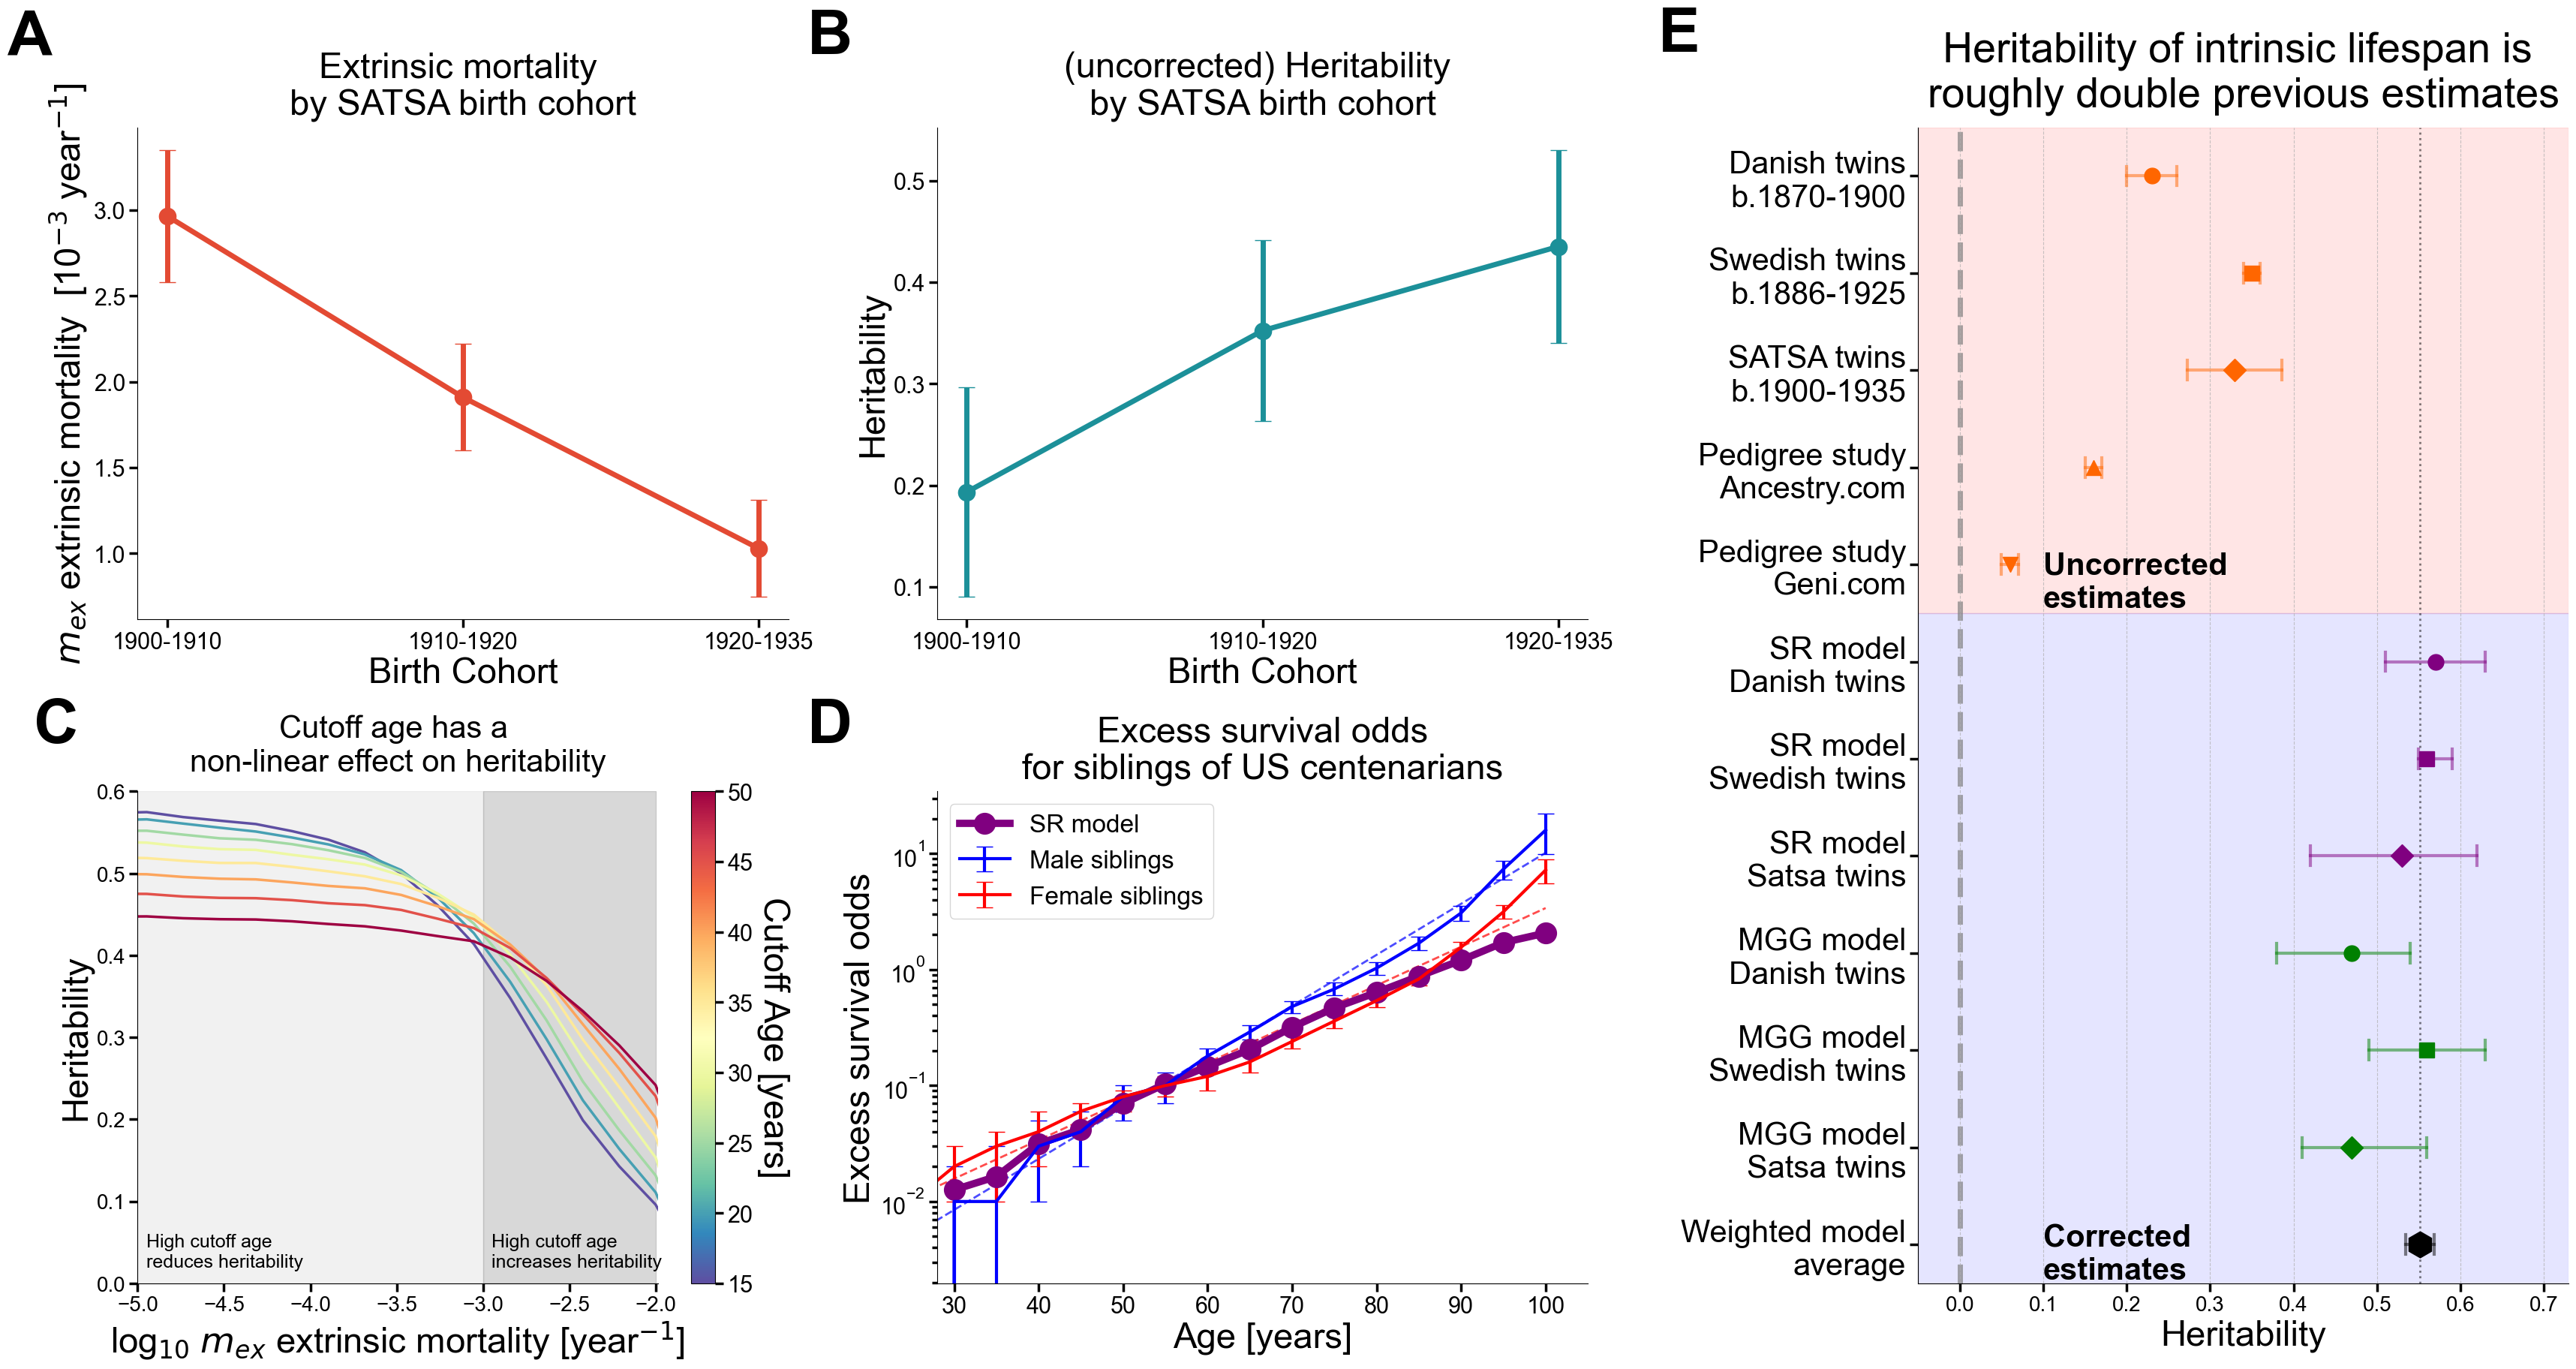

In [22]:

# Apply theme + keep text editable (PDF/SVG) + Arial font
mpl.rcParams.update(THEME)
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['text.usetex'] = False
mpl.rcParams['font.family'] = 'Arial'

# Layout constants
WSPACE = 0.3
HSPACE = 0.35
LEFT = 0.05
RIGHT = 0.95
SPACER = 0.05  # controls whitespace between middle column and forest plot

# Figure + GridSpec with a spacer column (col=2)
fig = plt.figure(figsize=(36, 20))
gs = fig.add_gridspec(2, 4, width_ratios=[1, 1, SPACER, 1], wspace=WSPACE, hspace=HSPACE)
axA = fig.add_subplot(gs[0, 0])
axB = fig.add_subplot(gs[0, 1])
axC = fig.add_subplot(gs[1, 0])
axD = fig.add_subplot(gs[1, 1])
forest_ax = fig.add_subplot(gs[:, 3])
fig.subplots_adjust(left=LEFT, right=RIGHT)

# =============================================================================
# DATA PREPARATION
# =============================================================================
# results from SATSA analysis
birth_cohorts = {
    '1900-1910': {'m_ex': 0.002965, 'm_ex_std': 0.000386, 'heritability': 0.1934, 'heritability_std': 0.1033, 'n': 363},
    '1910-1920': {'m_ex': 0.001909, 'm_ex_std': 0.000310, 'heritability': 0.3523, 'heritability_std': 0.0890, 'n': 424},
    '1920-1935': {'m_ex': 0.001028, 'm_ex_std': 0.000282, 'heritability': 0.4351, 'heritability_std': 0.0953, 'n': 339},
    '1900-1935': {'m_ex': 0.001994, 'm_ex_std': 0.000856, 'heritability': 0.3283, 'heritability_std': 0.0567, 'n': 1042}
}
cohorts_to_plot = list(birth_cohorts.keys())[:3]
x_pos = np.arange(len(cohorts_to_plot))

mortality_color = '#e34a33'
heritability_color = '#1c9099'

# =============================================================================
# (A) EXTRINSIC MORTALITY BY BIRTH COHORT
# =============================================================================
m_ex_values = [birth_cohorts[c]['m_ex'] for c in cohorts_to_plot]
m_ex_std = [birth_cohorts[c]['m_ex_std'] for c in cohorts_to_plot]
m_ex_values = np.array(m_ex_values) * 1e3
m_ex_std = np.array(m_ex_std) * 1e3
axA.errorbar(x_pos, m_ex_values, yerr=m_ex_std, fmt='-o', color=mortality_color, markersize=16)
axA.set_xlabel('Birth Cohort')
axA.set_ylabel(r'$m_{ex}$ extrinsic mortality  [10$^{-3}$ year$^{-1}$]')
axA.set_title('Extrinsic mortality \nby SATSA birth cohort')
axA.set_xticks(x_pos)
axA.set_xticklabels(cohorts_to_plot)

# =============================================================================
# (B) HERITABILITY BY BIRTH COHORT
# =============================================================================
heritability_values = [birth_cohorts[c]['heritability'] for c in cohorts_to_plot]
heritability_std = [birth_cohorts[c]['heritability_std'] for c in cohorts_to_plot]
axB.errorbar(x_pos, heritability_values, yerr=heritability_std, fmt='-o', color=heritability_color, markersize=16)
axB.set_xlabel('Birth Cohort')
axB.set_ylabel('Heritability')
axB.set_title('(uncorrected) Heritability \nby SATSA birth cohort')
axB.set_xticks(x_pos)
axB.set_xticklabels(cohorts_to_plot)

# =============================================================================
# (C) HERITABILITY VS EXTRINSIC MORTALITY
# =============================================================================
plot_metric_vs_extrinsic_mortality(axC, add_data=False, cohort='danish', model='sr', metric='h2', max_age=50)

# =============================================================================
# (D) EXCESS SURVIVAL PROBABILITY
# =============================================================================
axD.errorbar(df['Age'], df['esp_male'], yerr=male_yerr, fmt='o-', color='blue', label='Male siblings', markersize=0, linewidth=3)
axD.errorbar(df['Age'], df['esp_female'], yerr=female_yerr, fmt='o-', color='red', label='Female siblings', markersize=0, linewidth=3)

male_mask = df['esp_male'] > 0
female_mask = df['esp_female'] > 0
if male_mask.sum() > 1:
    male_slope, male_intercept = np.polyfit(df['Age'][male_mask], np.log10(df['esp_male'][male_mask]), 1)
    axD.plot(df['Age'], 10**(male_slope * df['Age'] + male_intercept), '--', color='blue', alpha=0.7, linewidth=2)
if female_mask.sum() > 1:
    female_slope, female_intercept = np.polyfit(df['Age'][female_mask], np.log10(df['esp_female'][female_mask]), 1)
    axD.plot(df['Age'], 10**(female_slope * df['Age'] + female_intercept), '--', color='red', alpha=0.7, linewidth=2)

hp.plot_relative_survival_prob_to_age_conditional_on_age_Y(
    sim=usa_sim, ax=axD, ages_X=range(30, 101, 5),
    age_Y=100, filter_age=20, label='SR model',
    color='purple', marker='o', markersize=20, linewidth=7
)
axD.set_yscale('log')
axD.set_xlabel('Age [years]')
axD.set_ylabel('Excess survival odds')
axD.set_title('Excess survival odds\nfor siblings of US centenarians')
axD.set_xlim(28, 105)
axD.legend()

# =============================================================================
# (E) FOREST PLOT (spans both rows)
# =============================================================================
plot_heritability_forest_plot(forest_ax)

# =============================================================================
# ADD SUBPLOT LABELS
# =============================================================================
labels = ['A', 'B', 'C', 'D', 'E']
subplot_axes = [axA, axB, axC, axD, forest_ax]
for label, ax in zip(labels, subplot_axes):
    if label == 'E':
        y_pos = 1.066
    elif label in ['A', 'B']:
        y_pos = 1.15
    else:
        y_pos = 1.1
    x_pos = -0.4 if label == 'E' else -0.2
    ax.text(x_pos, y_pos, label, transform=ax.transAxes, fontsize=60, fontweight='bold')

plt.show()

mpl.rcParams.update({
    'pdf.fonttype': 42,       # keep text as TrueType (editable)
    'ps.fonttype': 42,
    'svg.fonttype': 'none',   # if you also save SVGs
    'text.usetex': False,     # LaTeX often hurts editability
    'font.family': 'Arial',   # your preference [[memory:3782368]]
    'savefig.transparent': False,  # avoids rasterization from blending
})

